In [2]:
from qiskit import ClassicalRegister, QuantumCircuit, QuantumRegister
from qiskit.visualization import plot_histogram
import numpy as np
import matplotlib.pyplot as plt
import bitstring
from qiskit_aer import AerSimulator

from qiskit.quantum_info.operators import Operator, Pauli, SparsePauliOp
from qiskit.converters import circuit_to_instruction
from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2 as Estimator
from qiskit_ibm_runtime.fake_provider import FakeManilaV2
from qiskit.primitives import StatevectorEstimator
from qiskit.quantum_info import Statevector

#from qiskit import IBMQ, Aer

In [142]:
def rot_surf_code(n: int) -> QuantumCircuit:              #first ancilla = second last qubit = syndrome/parity measurement qubit, secondt ancilla = last qubit = magic state for T Gate
    qr = QuantumRegister(9*n+2, "q")
    cbit = ClassicalRegister(4,"c")
    qc = QuantumCircuit(qr,cbit)
    list = []
    for i in range(0, 9*n):
        list.append("{:c}".format(i))
    list = qr
    for i in range(n):
        qc.h(list[9*i+1])
        qc.h(list[9*i+3])
        qc.h(list[9*i+5])
        qc.h(list[9*i+7])

        qc.cx(list[9*i+1],list[9*i])
        qc.cx(list[9*i+5],list[9*i+4])
        qc.cx(list[9*i+7],list[9*i+8])

        qc.cx(list[9*i+5],list[9*i+2])

        qc.cx(list[9*i+3],list[9*i+4])
        qc.cx(list[9*i+2],list[9*i+1])

        qc.cx(list[9*i+3],list[9*i+6])

        qc.cx(list[9*i+6],list[9*i+7])
    return qc

{'0': 48, '1': 52}


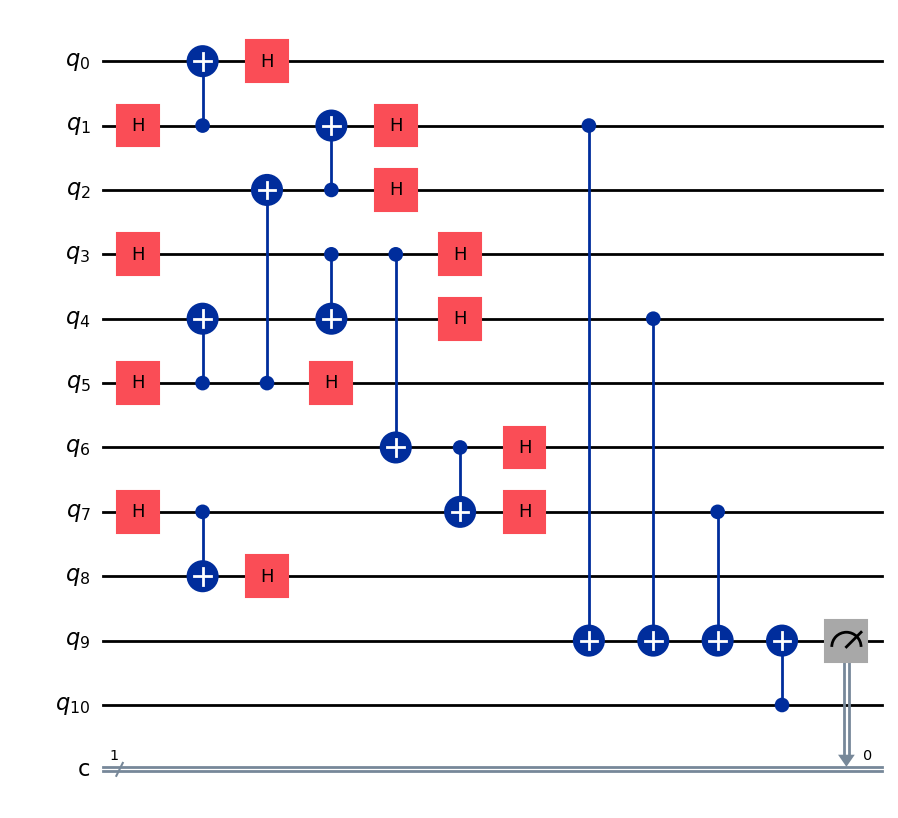

In [70]:
qc = rot_surf_code(1)         #Parity Measurement in Z-Basis --> Funktioniert!

for i in range(9):
    qc.h(i)

#qc.x(1)
#qc.x(4)
#qc.x(7)

qc.cx(1,9)
qc.cx(4,9)
qc.cx(7,9)

#qc.x(10)
qc.cx(10,9)

qc.measure(9,0)

sim = AerSimulator()
job = sim.run(qc, shots=100)
result = job.result()
counts = result.get_counts()
print(counts)

qc.draw("mpl")

{'1': 69}


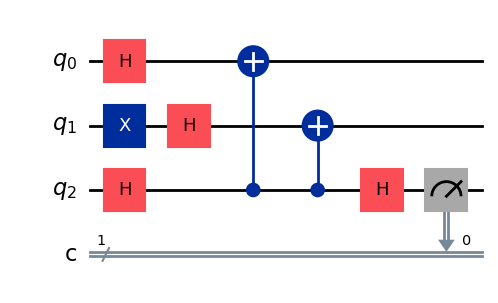

In [46]:
qr = QuantumRegister(3,"q")             #Parity Measurement in X-Basis --> Funktioniert!
cbit = ClassicalRegister(1,"c")

qc = QuantumCircuit(qr,cbit)

qc.h(0)
qc.x(1)
qc.h(1)


qc.h(2)

qc.cx(2,0)
qc.cx(2,1)

qc.h(2)

qc.measure(2,0)

sim = AerSimulator()
job = sim.run(qc, shots=69)
result = job.result()
counts = result.get_counts()
print(counts)
qc.draw("mpl")

{'1': 100}


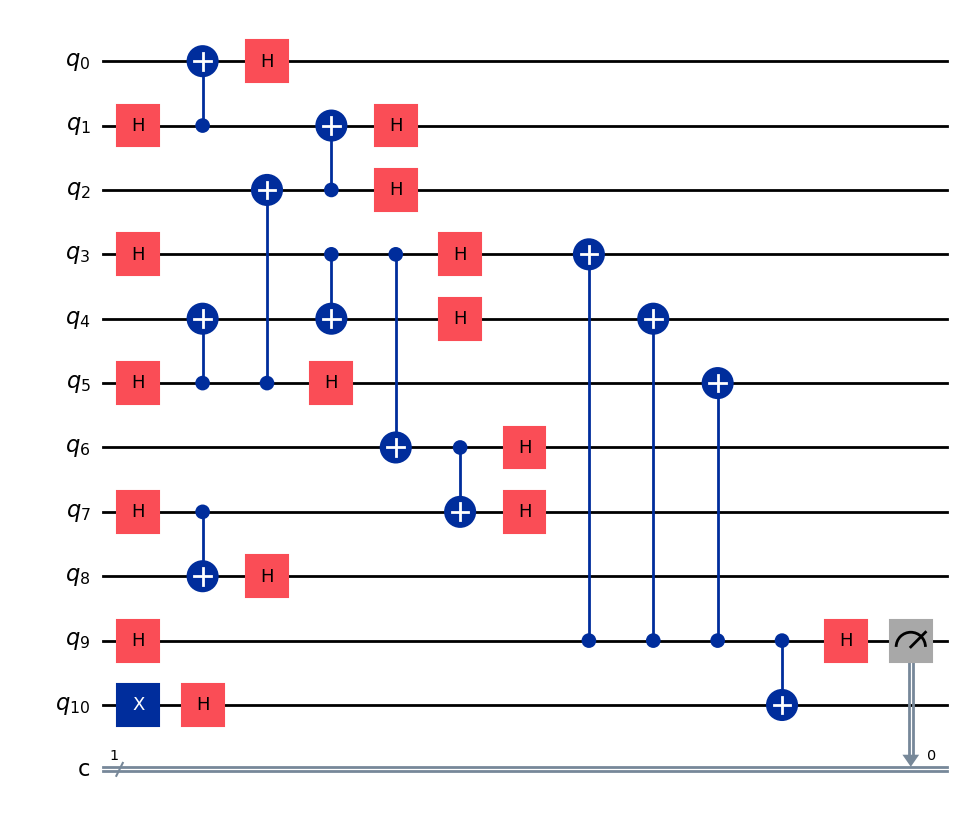

In [51]:
qc = rot_surf_code(1)         #Parity Measurement in X-Basis --> funktioniert!
#qc.z(3)
#qc.z(4)
#qc.z(5)

for i in range(9):
    qc.h(i)
                                #Initliasieren der Qubits für Parity Measruement

qc.x(10)
qc.h(10)

####################################################################

qc.h(9)

qc.cx(9,3)
qc.cx(9,4)
qc.cx(9,5)

qc.cx(9,10)

qc.h(9)

qc.measure(9,0)

sim = AerSimulator()
job = sim.run(qc, shots=100)
result = job.result()
counts = result.get_counts()
print(counts)

qc.draw("mpl")

{'1': 69}


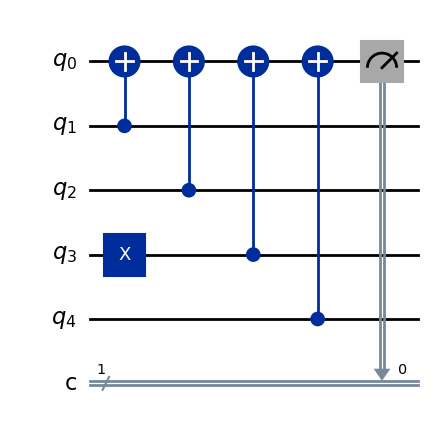

In [102]:
qr = QuantumRegister(5,"q")             #Parity Measurement in X-Basis --> Funktioniert!
cbit = ClassicalRegister(1,"c")

qc = QuantumCircuit(qr,cbit)


qc.x(3)

for i in range(4):
    qc.cx(1+i,0)

qc.measure(0,0)

sim = AerSimulator()
job = sim.run(qc, shots=69)
result = job.result()
counts = result.get_counts()
print(counts)
qc.draw("mpl")

{'0': 30, '1': 39}


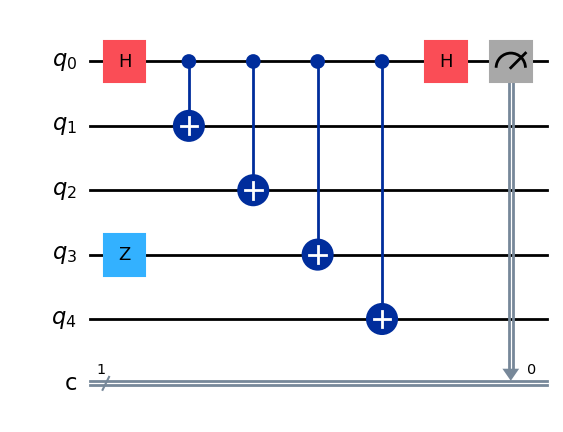

In [105]:
qr = QuantumRegister(5,"q")             #Parity Measurement in X-Basis --> Funktioniert!
cbit = ClassicalRegister(1,"c")

qc = QuantumCircuit(qr,cbit)


qc.z(3)

qc.h(0)
for i in range(4):
    qc.cx(0,1+i)
qc.h(0)
qc.measure(0,0)

sim = AerSimulator()
job = sim.run(qc, shots=69)
result = job.result()
counts = result.get_counts()
print(counts)
qc.draw("mpl")

In [153]:
def X_L(circuit: QuantumCircuit, hadamard: False, n=0):            #n muss bei 0 anfangen, also z.B. man hat 3 Circuits und will X_L auf den ersten anwenden ---> n = 0 !!!
    if hadamard:
        for i in range(9):
            circuit.x(9*n+3)
            circuit.x(9*n+4)
            circuit.x(9*n+5)
    else:
        for i in range(9):
            circuit.x(9*n+1)
            circuit.x(9*n+4)
            circuit.x(9*n+7)
    return circuit

def Z_L(circuit: QuantumCircuit, hadamard: False, n=0):            #n muss bei 0 anfangen, also z.B. man hat 3 Circuits und will Z_L auf den ersten anwenden ---> n = 0 !!!
    if hadamard:
        for i in range(9):
            circuit.z(9*n+1)
            circuit.z(9*n+4)
            circuit.z(9*n+7)
    else:
        for i in range(9):
            circuit.z(9*n+3)
            circuit.z(9*n+4)
            circuit.z(9*n+5)
    return circuit

def Hadmard(circuit: QuantumCircuit, n=0):              #H-Gates auf EINEN Circuit, wieder erster Circuit --> n = 0, zweiter Circuit --> n = 1 , usw.
    for i in range(9):
        circuit.h(9*n+i)
    return circuit

def CNOT(circuit:QuantumCircuit, control: int):               #ich programmiers jetzt mal nur für den Spezialfall von 2 Circuits
    if control == 0:
        for i in range(9):
            circuit.cx(control_qubit=i,target_qubit=9+i)
    elif control == 1: 
        for i in range(9):
            circuit.cx(control_qubit=9+i,target_qubit=i)
    else:
        return print("Noch nicht gecoded!")
    return circuit

def logical_S(circuit: QuantumCircuit, n=0):
    for i in range(9):
        circuit.z(9*n+i)
        circuit.s(9*n+i)
    return circuit

def adjoint_logical_S(circuit: QuantumCircuit, n=0):
    for i in range(9):
        circuit.z(9*n+i)
        circuit.sdg(9*n+i)
    return circuit

def stabilize(circuit: QuantumCircuit, pos = 0):                     #misst alle stabilizer, speichert den Fehler und korrigiert dementsprechend
    qc = circuit
    
    #X0 X1 Stabilizer:
    qc.reset(9+9*pos)
    qc.h(9+9*pos)
    qc.cx(9+9*pos,0+9*pos)
    qc.cx(9+9*pos,1+9*pos)
    qc.h(9+9*pos)
    qc.measure(9+9*pos,0)
    with qc.if_test((0,1)):
        qc.z(0+9*pos)
    
    #X1 X2 X4 X5 Stabilizer:
    qc.reset(9+9*pos)
    qc.h(9+9*pos)
    qc.cx(9+9*pos,1+9*pos)
    qc.cx(9+9*pos,2+9*pos)
    qc.cx(9+9*pos,4+9*pos)
    qc.cx(9+9*pos,5+9*pos)
    qc.h(9+9*pos)
    qc.measure(9+9*pos,1)

    #X3 X4 X6 X7 Stabilizer:
    qc.reset(9+9*pos)
    qc.h(9+9*pos)
    qc.cx(9+9*pos,3+9*pos)
    qc.cx(9+9*pos,4+9*pos)
    qc.cx(9+9*pos,6+9*pos)
    qc.cx(9+9*pos,7+9*pos)
    qc.h(9+9*pos)
    qc.measure(9+9*pos,2)

    #X7 X8 Stabilizer:
    qc.reset(9+9*pos)
    qc.h(9+9*pos)
    qc.cx(9+9*pos,7+9*pos)
    qc.cx(9+9*pos,8+9*pos)
    qc.h(9+9*pos)
    qc.measure(9+9*pos,3)
    with qc.if_test((3,1)):
        qc.z(7+9*pos)

    with qc.if_test((2,1)) and qc.if_test((1,1)):
        qc.z(4+9*pos)

    with qc.if_test((1,1)) and qc.if_test((2,0)):
        qc.z(2+9*pos)

    with qc.if_test((2,1)) and qc.if_test((1,0)):
        qc.z(3+9*pos)

###########################################################################################################

    #Z3 Z6 Stabilizer:
    qc.reset(9+9*pos)
    qc.cx(3+9*pos,9+9*pos)
    qc.cx(6+9*pos,9+9*pos)
    qc.measure(9+9*pos,0)
    with qc.if_test((0,1)):
        qc.x(3+9*pos)

    #Z0 Z1 Z3 Z4 Stabilizer:
    qc.reset(9+9*pos)
    qc.cx(0+9*pos,9+9*pos)
    qc.cx(1+9*pos,9+9*pos)
    qc.cx(3+9*pos,9+9*pos)
    qc.cx(4+9*pos,9+9*pos)
    qc.measure(9+9*pos,1)
 
    #Z4 Z5 Z7 Z8 Stabilizer:
    qc.reset(9+9*pos)
    qc.cx(4+9*pos,9+9*pos)
    qc.cx(5+9*pos,9+9*pos)
    qc.cx(7+9*pos,9+9*pos)
    qc.cx(8+9*pos,9+9*pos)
    qc.measure(9+9*pos,2)

    #Z2 Z5 Stabilizer:
    qc.reset(9+9*pos)
    qc.cx(2+9*pos,9+9*pos)
    qc.cx(5+9*pos,9+9*pos)
    qc.measure(9+9*pos,3)
    with qc.if_test((3,1)):
        qc.x(2+9*pos)
    
    with qc.if_test((2,1)) and qc.if_test((1,1)):
        qc.z(4+9*pos)

    with qc.if_test((1,1)) and qc.if_test((2,0)):
        qc.z(1+9*pos)

    with qc.if_test((2,1)) and qc.if_test((1,0)):
        qc.z(7+9*pos)

    return qc

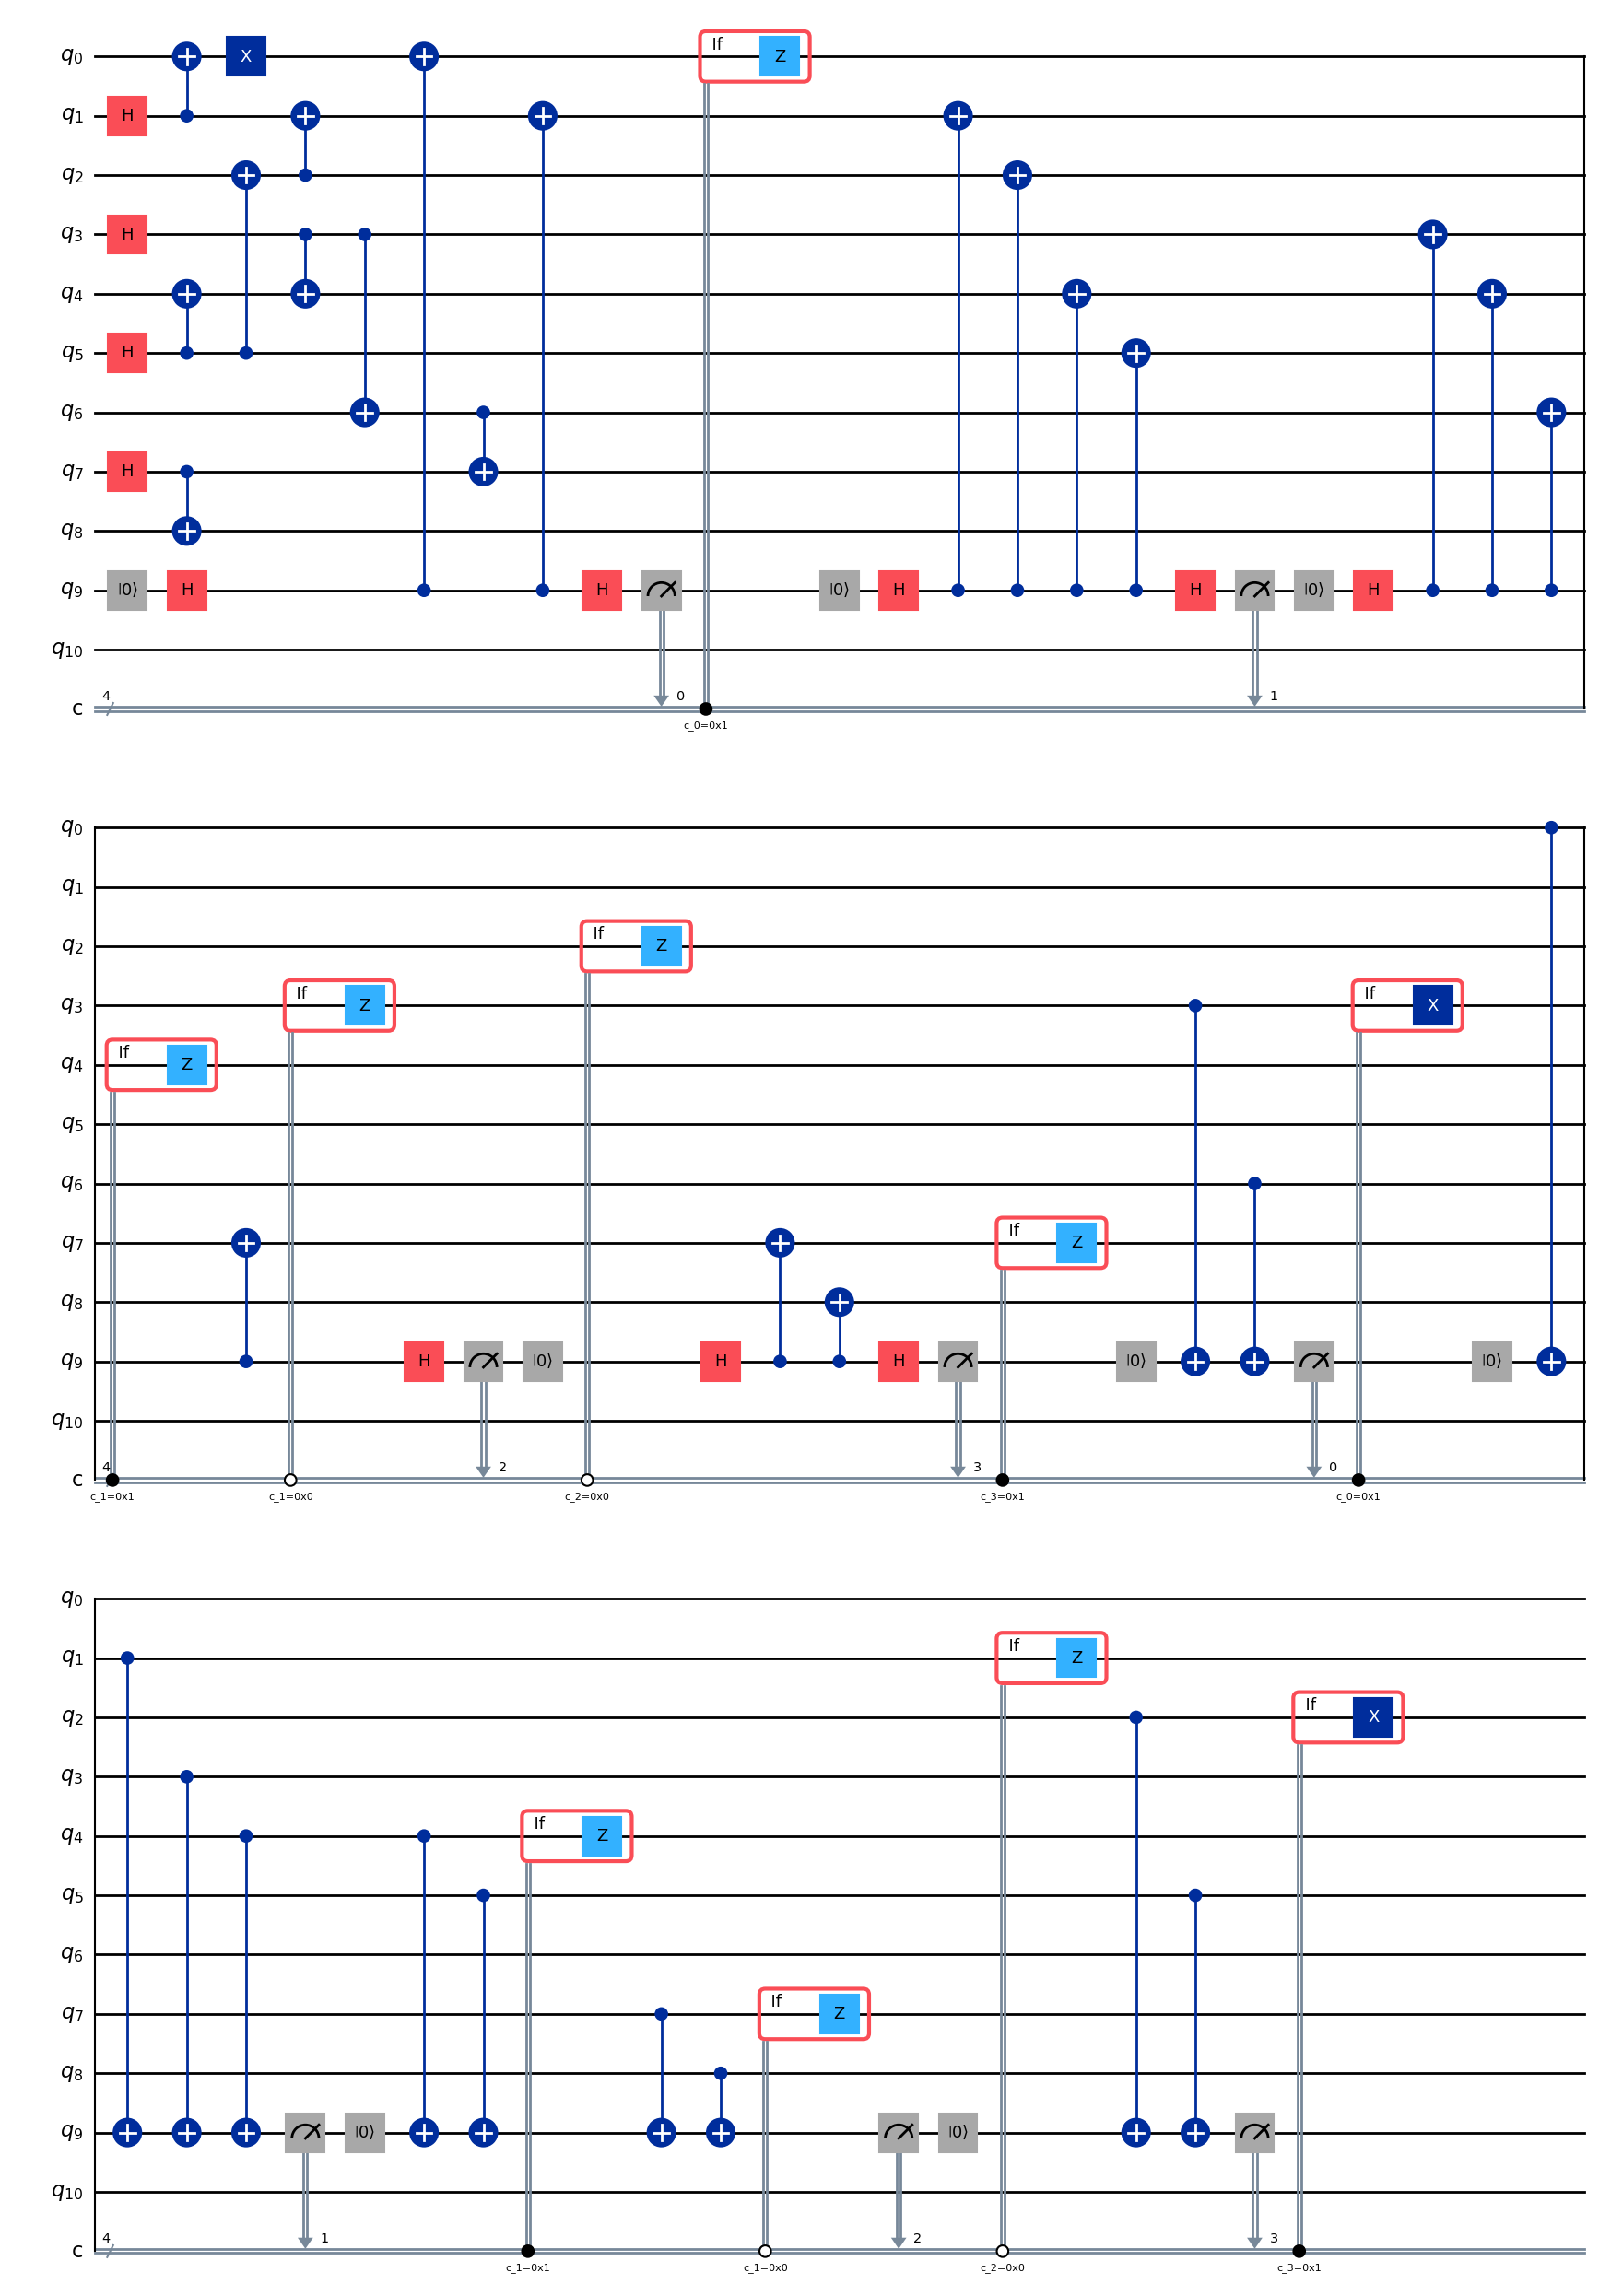

In [154]:
qc = rot_surf_code(1)

qc.x(0)

qc = stabilize(qc)

qc.draw("mpl")

[{'0001': 10}]


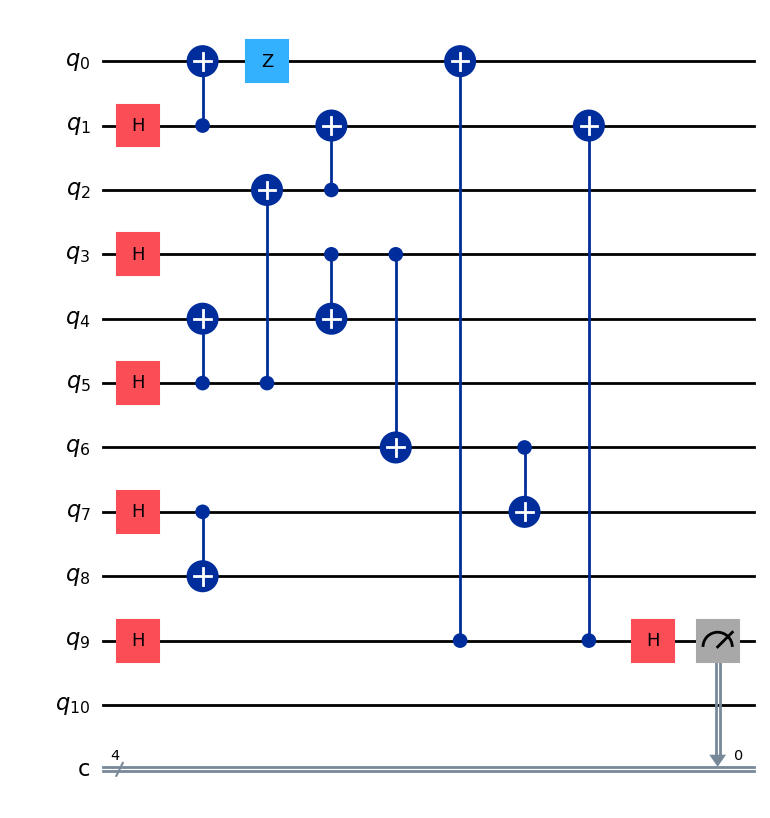

In [157]:
qc = rot_surf_code(1)

qc.z(0)
qc.h(9)
qc.cx(9,0)
qc.cx(9,1)
qc.h(9)
qc.measure(9,0)

heeeh = []

# with qc.if_test((0,0)):
#     print("Yesss")

sim = AerSimulator()
job = sim.run(qc, shots=10)
result = job.result()
result = job.result().get_counts(qc)
heeeh.append(result)
print(heeeh)

qc.draw("mpl")